In [84]:
#Importiere mehrere (Standard-)Packages
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties import unumpy
from scipy import optimize

#NiMoNa-Spezifisch
import scipy.sparse as sp


#um folgende Packages zu haben, muss man Sachen einfügen (siehe Durchschnittsphysiker-Ordner)
#Außerdem installieren:
#pip3 install antlr4-python3-runtime
from sympy import *
from __future__ import division
from process_latex import process_sympy


#Zum genaueren betrachten der Grafiken:
#%matplotlib notebook
init_printing() # enable latex ausgabe

# Blatt 05 (NiMoNa)

## Ziel:

Modellierung und Darstellung des Rumänischen Netzes

----------

### WICHTIG:
- theta[0] ist Theta
- theta[1] ist Theta-Punkt

## Teil 0 - Initialisieren

In [221]:
#Feste Zahlen

#Anzahl der Oszillatoren
N = 88 # aus Adjazenzmatrix

#Koppungsstärke (alt, jetzt exisitert Adjazenzmatrix)
K = 200

#Länge des Zeitintervalls
Nt = 1500000

output = 1000

#Schrittweite in der Zeit
dt = 0.01

#Faktor vor erster Ableitung
alpha = 0.1

#Adjazenz-Matrix laden
adjazenzmatrix = np.load("romAdj.npy")
#adjazenzmatrix = sp.csr_matrix(adjazenzmatrix)

#Thetas initialisieren (jeweils mit zwei Einträgen pro Oszillator)
theta = np.ndarray(shape=(N,2))
#theta = sp.csr_matrix(theta)

#Leistung P(j):
P = np.array([0.]*N)



    #Frequenzen der Oszis (noch aus vereinfachtem Modell)
    #omega = np.array([0.0]*N)
    #omega = np.random.standard_cauchy(N)

In [222]:
#---------------------------
#Zufallsverteilungen generieren
def initialisieren():
    #Phasen des Oszis
    #theta = np.array([0.0]*N)
    temp_verteilung = np.random.random(N)*np.pi
    omega = np.random.standard_cauchy(N)
    for i in range(0,N):
        theta[i,0] = temp_verteilung[i]
        theta[i,1] = 0#omega[i]
        
    #Leistung festsetzen:
    for i in range(0,int(N/2)):
        P[i] = 1
        P[2*i] = -1
        P[2*i +1] = -1
    P[N-1] = 1
    print(P)
    
    #überprüfen
    summe = 0
    for i in range(0,N):
        summe = summe + P[i]
    print("Summe aller P:",summe)
    print("Erfolgreich initialisiert")

In [223]:
initialisieren()

[-1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]
Summe aller P: 0.0
Erfolgreich initialisiert


In [224]:
adjazenzmatrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Teil 1 - Formeln und Funktionen

In [225]:
#Ordnungsparameter bestimmen
def ordnung(N,theta):
    #bertrachte Imaginärteil und Realteil des Parameters gesondert
    tempRe = 0
    tempIm = 0
    
    #Schleife um Summe der Theta zu berechnen
    for i in range(0,N):
        tempRe = tempRe + np.cos(theta[i,0])
        tempIm = tempIm + np.sin(theta[i,0])
        
    #Normieren um Mittelwert zu bekommen:
    tempRe = tempRe / N
    tempIm = tempIm / N
    
    #r und Phi berechnen
    r = (tempIm**2 + tempRe**2)**(1/2)
    phi = np.arccos(tempRe)
    
    return r,phi

In [245]:
#Kuramoto-Funktionen in 2d:
def fkt0(y_n):
    #für Theta
    return (y_n[1])

def fkt1(y_n, j):
    #Für Theta-Punkt -> eigentliche Kuramoto-Glg
    summe = 0
    for i in range(0,N):
        summe = summe + adjazenzmatrix[i,j] * np.sin(theta[i,0] - y_n[0])
    return P[j] - alpha * y_n[1] - summe

#Anwendung von RK4 (für j-ten Oszillator):
def kura_alt(y_n,j, schrittbreite):
    
    h = schrittbreite
    
    #ks initialisieren
    k1 = np.array([0.,0.])
    k2 = np.array([0.,0.])
    k3 = np.array([0.,0.])
    k4 = np.array([0.,0.])

    
    #Faktoren berechnen
    k1[0] = fkt0(y_n)
    k1[1] = fkt1(y_n,j)
    #print("k1 = ", k1)
    
    k2[0] = fkt0(y_n + h/2 * k1)
    k2[1] = fkt1(y_n + h/2 * k1,j)
    #print("k2 = ", k2)
    
    k3[0] = fkt0(y_n + h/2 * k2)
    k3[1] = fkt1(y_n + h/2 * k2,j)
    #print("k3 = ", k3)
    
    k4[0] = fkt0(y_n + h * k3)
    k4[1] = fkt1(y_n + h * k3,j)
    #print("k4 = ", k4)
    
    #neuen Funktionswert berechnen (2d!)
    y_neu = y_n + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)
    
    return y_neu

In [246]:
#schneller!

#Kuramoto-Funktionen in 2d:
def fkt_vec(y_n, j):
    summe = 0
    for i in range(0,N):
        summe = summe + adjazenzmatrix[i,j] * np.sin(theta[i,0] - y_n[0])
    y_neu = y_n
    y_neu[0] = y_n[1]
    y_neu[1] = P[j] - alpha * y_n[1] - summe
    return y_neu

#Anwendung von RK4 (für j-ten Oszillator):
def kura(y_n,j, h):
    #Faktoren berechnen
    k1 = fkt_vec(y_n,j)
    #print("k1 = ", k1)
    
    k2 = fkt_vec(y_n + h/2 * k1, j)
    #print("k2 = ", k2)
    
    k3 = fkt_vec(y_n + h/2 * k2,j)
    #print("k3 = ", k3)
    
    k4 = fkt_vec(y_n + h * k3,j)
    #print("k4 = ", k4)
    
    #neuen Funktionswert berechnen (2d!)    
    return y_n + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)

## Teil 2 - Daten

## Teil 3 - Hauptzelle(n)

[-1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]
Summe aller P: 0.0
Erfolgreich initialisiert
1
0.3256380145270845


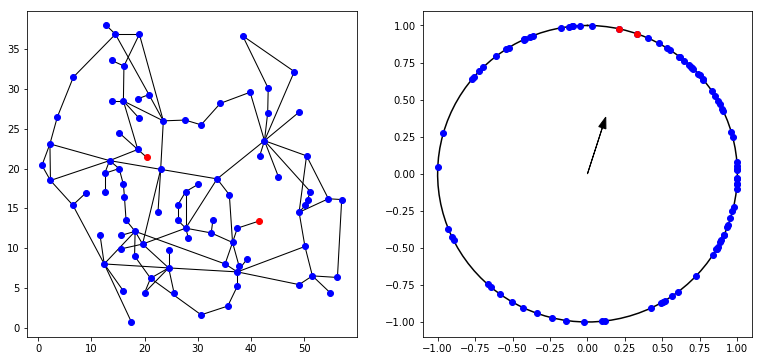

In [251]:
#zunächst zurücksetzen
initialisieren()

#dann berechnen
for i in range(0,Nt):
    #-------------------------------------------
    #RECHNEN

    
    #Nun alle neuen theta-Werte berechnen
    for j in range(0,N):
        #Kuramoto-Gleichung in RK-einsetzen für Oszillator j
        theta[j] = kura(theta[j],j,dt)
    
    
    #------------------------------------------
    #PLOTTEN
    if (i%(output/10) == 1): #um ziwschenstand anzuzeigen
        print(i)
    if (i%output == 1): #um Bilder zu plotten
        
        fig, axs = plt.subplots(1, 2, figsize=(13, 6)) #erzeugt zwei Bilder nebeneinander
        axs[0].plot() #erzeugt plot im ersten Bild
        axs[1].plot() #erzeugt plot im zweiten Bild
        
        
        
        #Ordnungsparameter berechnen
        r, phi = ordnung(N,theta)
        print(r)
        
        #dafür zunächst Variablen basteln:
        theta_0 = np.array([1.] * N)
        for l in range(0,N):
            theta_0[l] = theta[l,0]

    
        plt.figure("phases")
        
        #Kreis plotten
        an = np.linspace(0,2*np.pi,100)
        axs[1].plot(np.sin(an),np.cos(an), color="black")
        
        #Ordnungsparameter
        axs[1].arrow(0,0,r*np.cos(phi),r*np.sin(phi),head_width=0.05, color="black")
        
        #Oszis auf Kreis
        axs[1].plot(np.cos(theta_0),np.sin(theta_0),"o", color="blue")
        

        for l in range(0,N):
            
            #Verbindungen plotten
            for k in range(l,N):
                if (adjazenzmatrix[l,k] == 1.):
                    x = np.array([position[l,0],position[k,0]])
                    y = np.array([position[l,1],position[k,1]])
                    axs[0].plot(x,y,"-", color="black",linewidth=1.05)
            
            #synchronisierung checken
            if (abs(theta_0[l] - phi) <= 0.1): 
                axs[0].plot(position[l,0],position[l,1],"o", color="red")
                axs[1].plot(np.cos(theta_0[l]),np.sin(theta_0[l]),"o", color="red")
            else:
                #sonst Punkt normal plotten
                axs[0].plot(position[l,0],position[l,1],"o", color="blue") 
                    

        plt.draw()

        #Abspeichern der Daten
        fileName = "video/phases_g"+str(i)+".png"
        fig.savefig(fileName,dpi=400)
        plt.show(block=False)

        plt.pause(0.01)

## Teil 4 - Probieren

In [71]:
b = np.array([1,0])
c = np.array(["eins","drei"])
a = zip(b,c)

In [72]:
list(a)

[(1, 'eins'), (0, 'drei')]

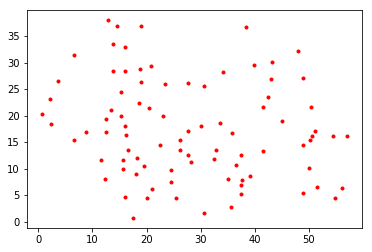

In [81]:
for i in range(N):
    plt.plot(position[i,0],position[i,1],".", color="red")

In [78]:
position[0]

array([ 0.7, 20.4])

In [231]:
adjazenzmatrix[0,1]
plt.plot()

In [208]:
ergebnis = sp.csr_matrix(adjazenzmatrix)
print(ergebnis[1,0])

1.0


In [205]:
adjazenzmatrix[1]

array([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])